In [5]:
import os
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import numpy as np
import pandas as pd
import random as ran
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras import  models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD

In [6]:
image_dir = os.path.dirname(os.getcwd())+"\\Screenshots\\with_distance_labels\\"
filenames = os.listdir(image_dir)
labels = [x.split("_")[0] for x in filenames]
img = [imread(image_dir + x) for x in filenames]
distances = pd.to_numeric([x.split("_")[1] for x in filenames], errors='coerce')
data = pd.DataFrame({"filename": filenames, "label": labels, "img": img, "distance": distances})


data = data.reset_index()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1232 non-null   int64  
 1   filename  1232 non-null   object 
 2   label     1232 non-null   object 
 3   img       1232 non-null   object 
 4   distance  1232 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 48.3+ KB


In [7]:
#Splitting the data into training and testing
train_df, test_df = train_test_split(data, test_size=0.3)

# Datagen for training data. Augment the data by rotating, shifting, flipping, to make the model more robust and less prone to overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory=image_dir,
    target_size=(64, 64),
    x_col='filename',
    y_col='label',
    batch_size=32,
    class_mode='categorical'  # or 'categorical' based on your problem
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode= "categorical"  # or 'categorical'
)

# Creating a new generator that also yields distance
def combined_generator(generator, df):
    while True:
        # Get next batch from the original generator
        x, y = next(generator)
        # Get indices of the dataframe rows used in this batch (use filenames to match)
        _filenames = generator.filenames[generator.batch_index - 1:generator.batch_index - 1 + generator.batch_size]
        # Extract distances using the filenames to match indices
        _distances = df[df['filename'].isin(_filenames)]['distance'].values
        # Ensure the distance array matches the batch size, especially for the last batch
        _distances = np.resize(_distances, (x.shape[0],))
        # Yield the image batch and both outputs
        yield x, (y, _distances)

# Use the new generator
train_combined_generator = combined_generator(train_generator, train_df)
test_combined_generator = combined_generator(test_generator, test_df)

Found 862 validated image filenames belonging to 5 classes.
Found 370 validated image filenames belonging to 5 classes.


In [8]:

def plot_history(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

    plt.plot(np.array(model.history['loss'])-np.array(model.history['distance_output_mse']))
    plt.plot(np.array(model.history['val_loss'])-np.array(model.history['val_distance_output_mse']))
    plt.title('Classification loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

    plt.plot(model.history['class_output_accuracy'])
    plt.plot(model.history['val_class_output_accuracy'])
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

    plt.plot(model.history['distance_output_mse'])
    plt.plot(model.history['val_distance_output_mse'])
    plt.title('Distance Accuracy (MSE)')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - class_output_accuracy: 0.2357 - distance_output_mse: 246.2351 - loss: 247.8530 - val_class_output_accuracy: 0.3432 - val_distance_output_mse: 177.0851 - val_loss: 178.6723
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - class_output_accuracy: 0.3372 - distance_output_mse: 135.6404 - loss: 137.1232 - val_class_output_accuracy: 0.3432 - val_distance_output_mse: 141.0145 - val_loss: 142.3679
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - class_output_accuracy: 0.3395 - distance_output_mse: 109.5075 - loss: 110.8824 - val_class_output_accuracy: 0.3432 - val_distance_output_mse: 121.5561 - val_loss: 122.8940
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - class_output_accuracy: 0.3521 - distance_output_mse: 93.4527 - loss: 94.8175 - val_class_output_accuracy: 0.3486 - val_distance_output_mse: 119.6531 - val_loss: 120.9607
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - class_output_accuracy: 0.3923 - distance_output

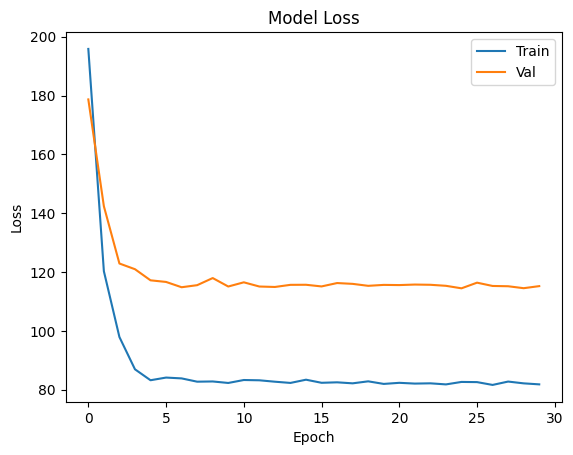

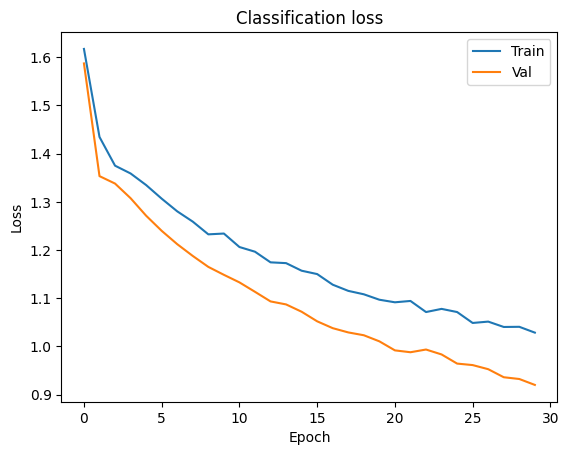

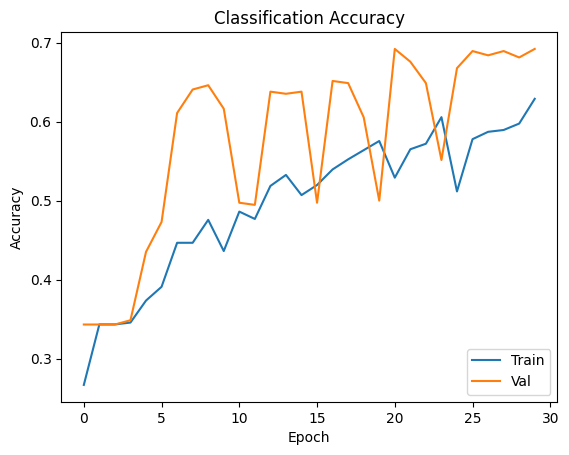

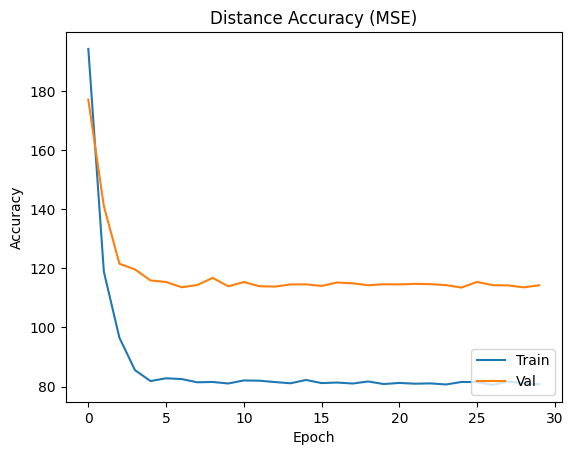

In [9]:
# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)

plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(np.array(trained_model.history['loss'])-np.array(trained_model.history['distance_output_mse']))
plt.plot(np.array(trained_model.history['val_loss'])-np.array(trained_model.history['val_distance_output_mse']))
plt.title('Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(trained_model.history['class_output_accuracy'])
plt.plot(trained_model.history['val_class_output_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

plt.plot(trained_model.history['distance_output_mse'])
plt.plot(trained_model.history['val_distance_output_mse'])
plt.title('Distance Accuracy (MSE)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - class_output_accuracy: 0.2360 - distance_output_mse: 190.2146 - loss: 191.8664 - val_class_output_accuracy: 0.2892 - val_distance_output_mse: 140.1891 - val_loss: 141.6846
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - class_output_accuracy: 0.3668 - distance_output_mse: 98.1272 - loss: 99.5672 - val_class_output_accuracy: 0.4568 - val_distance_output_mse: 139.8181 - val_loss: 141.0845
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - class_output_accuracy: 0.4468 - distance_output_mse: 98.2171 - loss: 99.4755 - val_class_output_accuracy: 0.5189 - val_distance_output_mse: 132.7779 - val_loss: 133.9857
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - class_output_accuracy: 0.5019 - distance_output_mse: 96.2427 - loss: 97.4472 - val_class_output_accuracy: 0.5000 - val_distance_output_mse: 131.3754 - val_loss: 132.4902
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - class_output_accuracy: 0.4794 - distance_output_

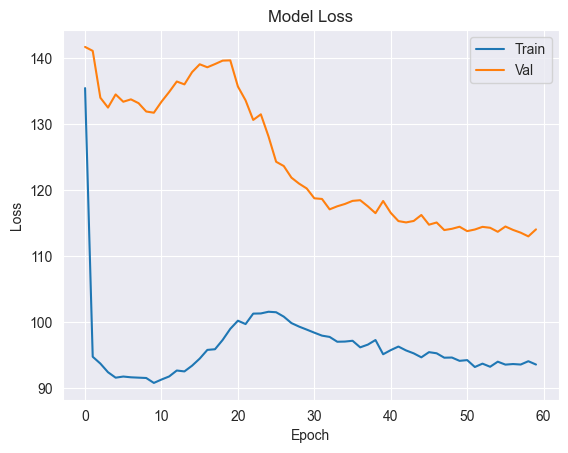

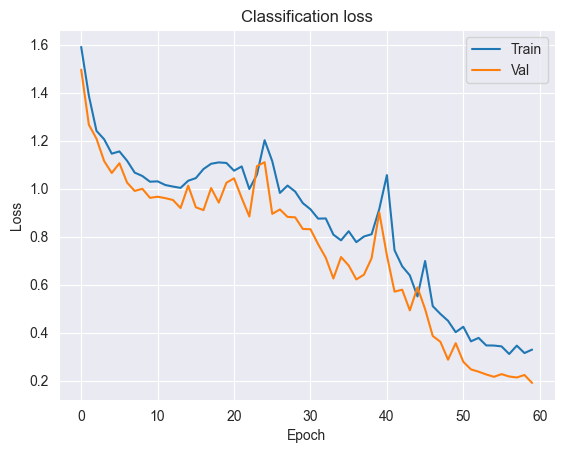

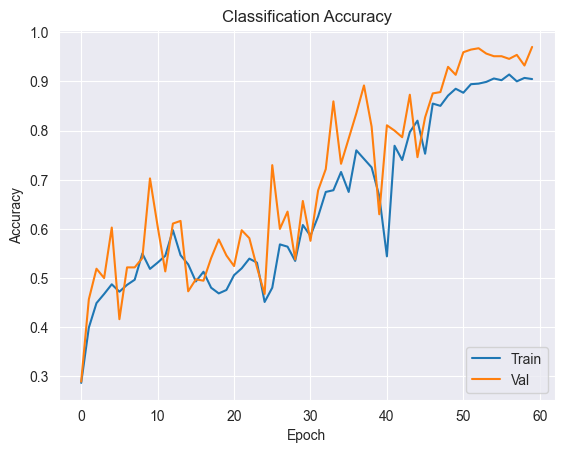

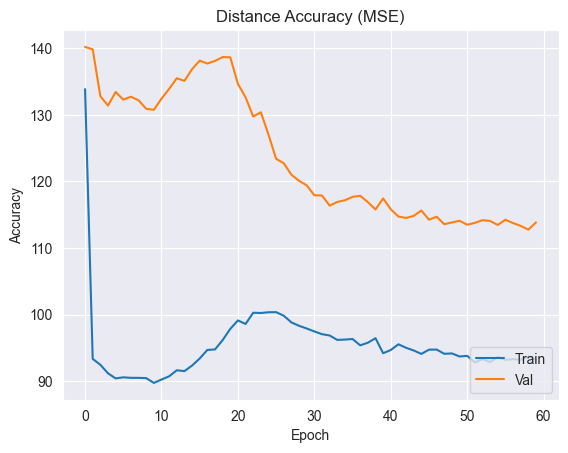

In [23]:
# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)

plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(np.array(trained_model.history['loss'])-np.array(trained_model.history['distance_output_mse']))
plt.plot(np.array(trained_model.history['val_loss'])-np.array(trained_model.history['val_distance_output_mse']))
plt.title('Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(trained_model.history['class_output_accuracy'])
plt.plot(trained_model.history['val_class_output_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

plt.plot(trained_model.history['distance_output_mse'])
plt.plot(trained_model.history['val_distance_output_mse'])
plt.title('Distance Accuracy (MSE)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - class_output_accuracy: 0.2770 - distance_output_mse: 186.7800 - loss: 188.9035 - val_class_output_accuracy: 0.2649 - val_distance_output_mse: 112.4000 - val_loss: 113.9285
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - class_output_accuracy: 0.2921 - distance_output_mse: 92.8966 - loss: 94.4636 - val_class_output_accuracy: 0.4514 - val_distance_output_mse: 124.2965 - val_loss: 125.6842
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - class_output_accuracy: 0.4038 - distance_output_mse: 94.3795 - loss: 95.8159 - val_class_output_accuracy: 0.3757 - val_distance_output_mse: 136.1668 - val_loss: 137.4427
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - class_output_accuracy: 0.4679 - distance_output_mse: 96.2767 - loss: 97.5050 - val_class_output_accuracy: 0.5027 - val_distance_output_mse: 139.7650 - val_loss: 140.9527
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - class_output_accuracy: 0.4118 - distance_output_

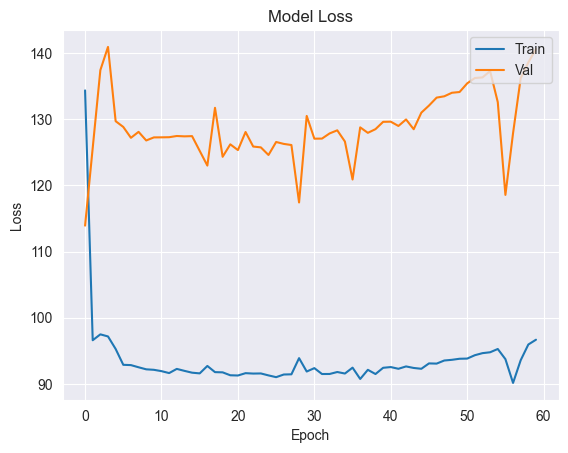

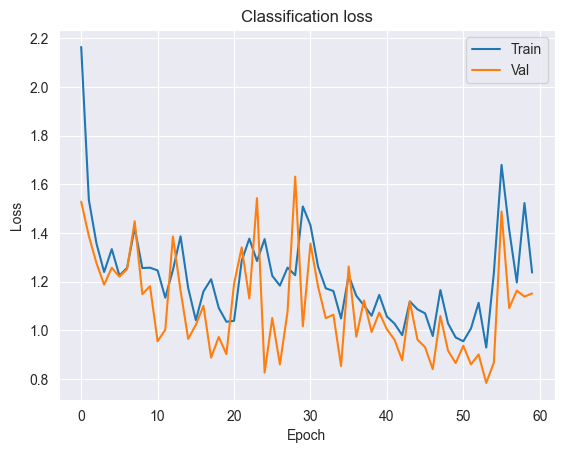

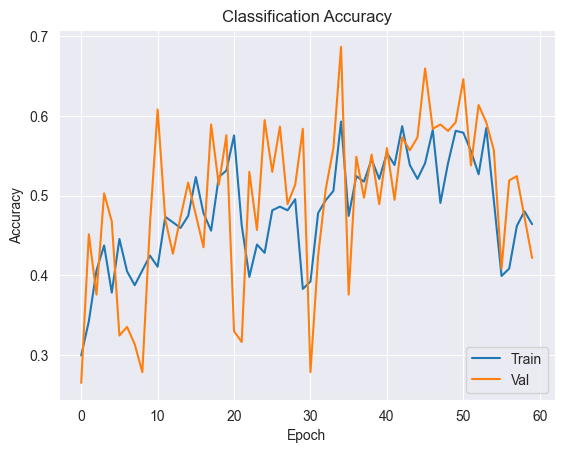

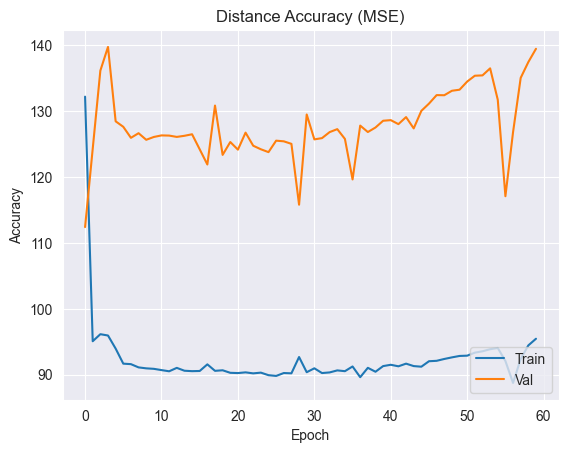

In [24]:
# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.005),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)

plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(np.array(trained_model.history['loss'])-np.array(trained_model.history['distance_output_mse']))
plt.plot(np.array(trained_model.history['val_loss'])-np.array(trained_model.history['val_distance_output_mse']))
plt.title('Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(trained_model.history['class_output_accuracy'])
plt.plot(trained_model.history['val_class_output_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

plt.plot(trained_model.history['distance_output_mse'])
plt.plot(trained_model.history['val_distance_output_mse'])
plt.title('Distance Accuracy (MSE)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - class_output_accuracy: 0.2784 - distance_output_mse: 324.3657 - loss: 325.9655 - val_class_output_accuracy: 0.3703 - val_distance_output_mse: 342.5307 - val_loss: 344.1316
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - class_output_accuracy: 0.2838 - distance_output_mse: 323.1552 - loss: 324.7538 - val_class_output_accuracy: 0.3541 - val_distance_output_mse: 341.3141 - val_loss: 342.9152
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - class_output_accuracy: 0.2886 - distance_output_mse: 322.0359 - loss: 323.6356 - val_class_output_accuracy: 0.2946 - val_distance_output_mse: 339.9564 - val_loss: 341.5572
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - class_output_accuracy: 0.2913 - distance_output_mse: 320.6461 - loss: 322.2459 - val_class_output_accuracy: 0.3595 - val_distance_output_mse: 338.1674 - val_loss: 339.7677
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - class_output_accuracy: 0.3073 - distance_o

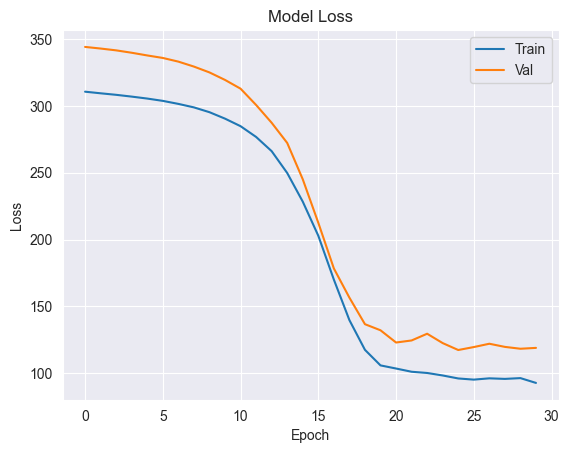

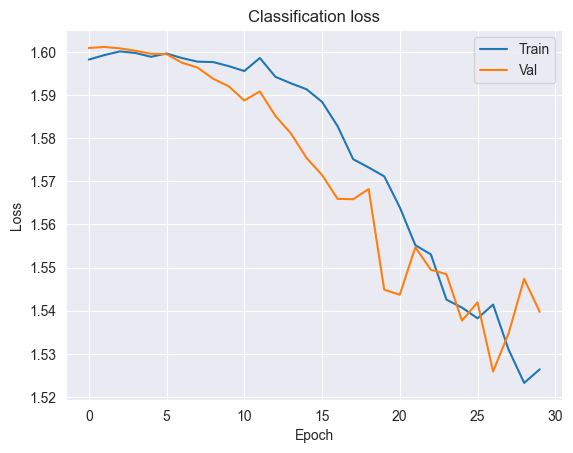

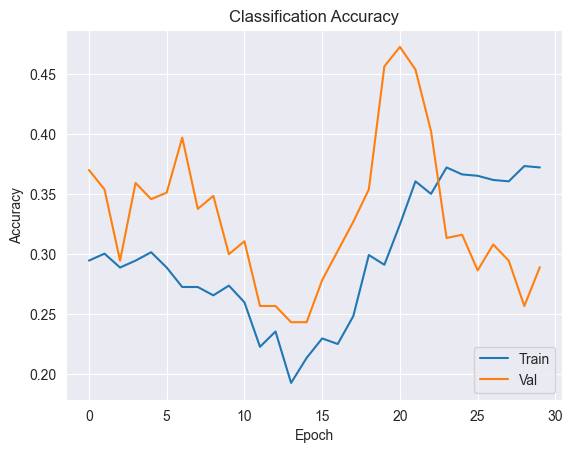

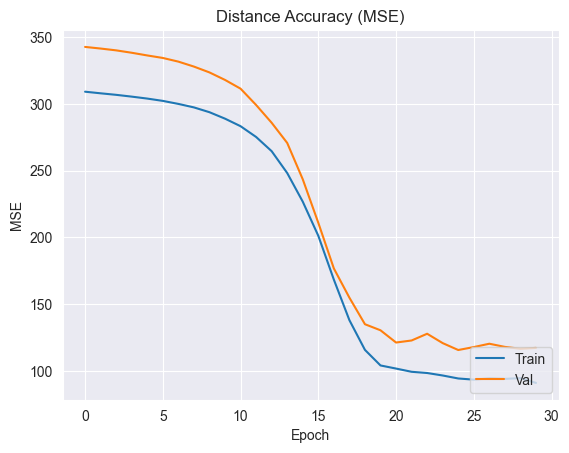

In [28]:
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=SGD(learning_rate=0.00001),
              loss={ 'distance_output': 'mse','class_output': 'categorical_crossentropy'},
              metrics={'distance_output': 'mse','class_output': 'accuracy', })

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - class_output_accuracy: 0.2226 - distance_output_mse: 308.5516 - loss: 310.1666 - val_class_output_accuracy: 0.3324 - val_distance_output_mse: 340.4772 - val_loss: 342.0873
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - class_output_accuracy: 0.2228 - distance_output_mse: 306.4346 - loss: 308.0485 - val_class_output_accuracy: 0.3432 - val_distance_output_mse: 337.1789 - val_loss: 338.7807
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - class_output_accuracy: 0.2365 - distance_output_mse: 303.2161 - loss: 304.8295 - val_class_output_accuracy: 0.2757 - val_distance_output_mse: 331.9241 - val_loss: 333.5297
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - class_output_accuracy: 0.2103 - distance_output_mse: 297.2087 - loss: 298.8289 - val_class_output_accuracy: 0.2892 - val_distance_output_mse: 322.6223 - val_loss: 324.2355
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - class_output_accuracy: 0.2455 - distance_ou

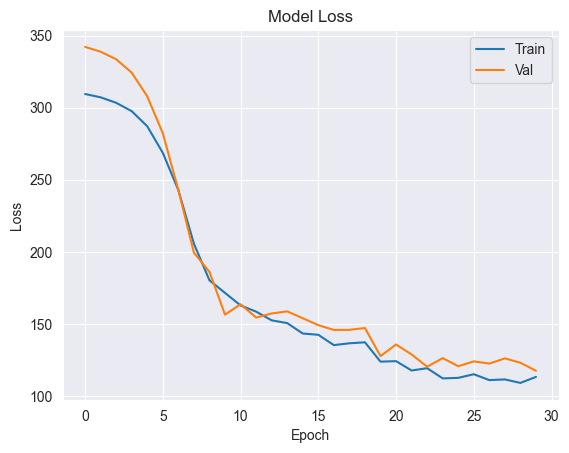

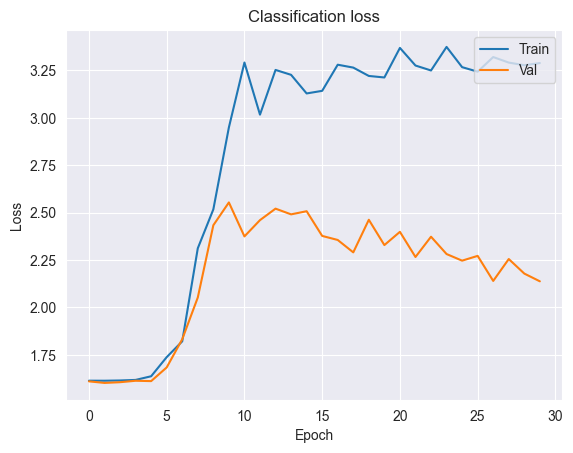

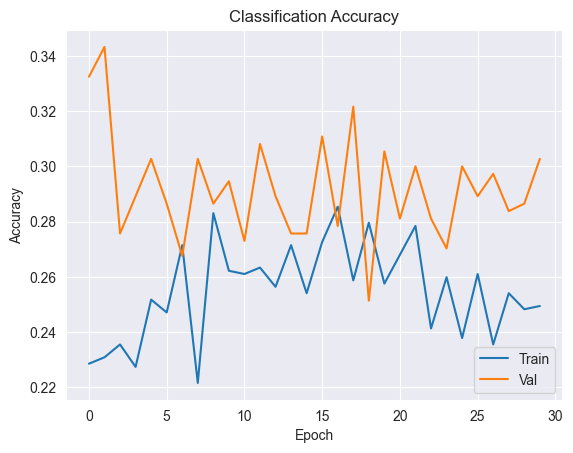

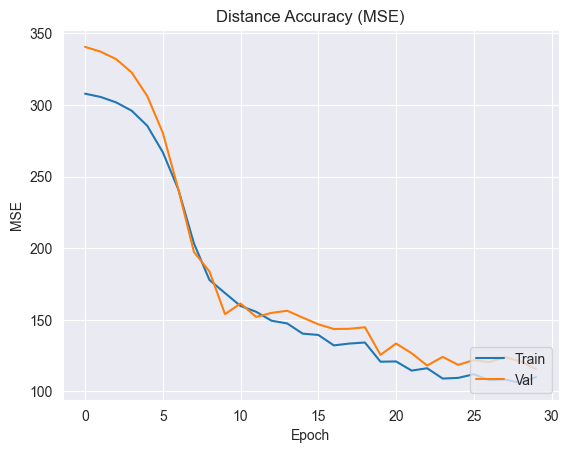

In [30]:
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Add the Dense layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss={ 'distance_output': 'mse','class_output': 'categorical_crossentropy'},
              metrics={'distance_output': 'mse','class_output': 'accuracy', })

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - class_output_accuracy: 0.2365 - distance_output_mse: 268.5056 - loss: 270.1476 - val_class_output_accuracy: 0.2946 - val_distance_output_mse: 220.6695 - val_loss: 222.6220
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - class_output_accuracy: 0.3642 - distance_output_mse: 176.0358 - loss: 177.9365 - val_class_output_accuracy: 0.2811 - val_distance_output_mse: 184.6363 - val_loss: 186.6934
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - class_output_accuracy: 0.3878 - distance_output_mse: 142.2115 - loss: 143.9888 - val_class_output_accuracy: 0.2919 - val_distance_output_mse: 139.9596 - val_loss: 141.6673
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - class_output_accuracy: 0.3628 - distance_output_mse: 103.5004 - loss: 105.1269 - val_class_output_accuracy: 0.2892 - val_distance_output_mse: 121.1291 - val_loss: 122.6931
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - class_output_accuracy: 0.3690 - distance_outpu

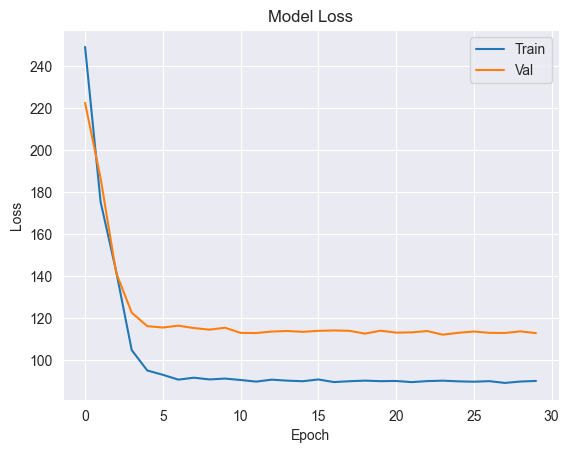

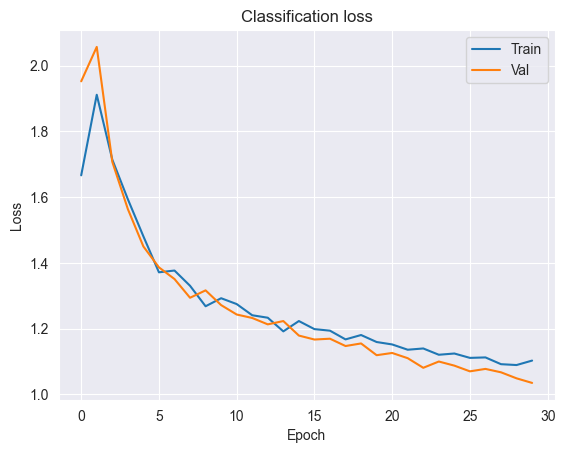

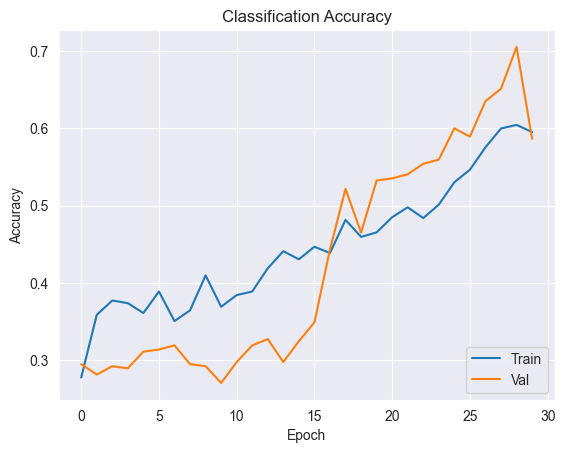

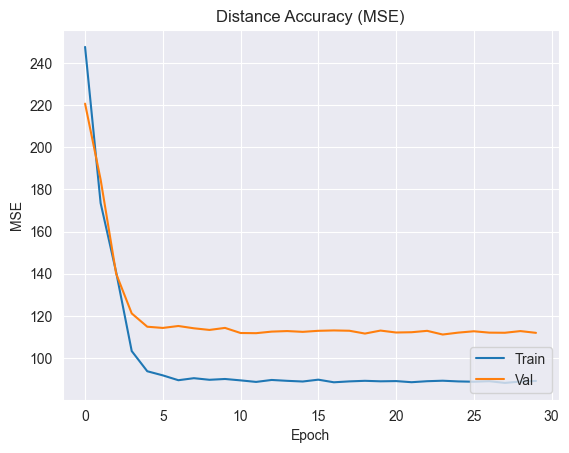

In [31]:
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Add the Dense layer
x = Dense(64, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - class_output_accuracy: 0.2011 - distance_output_mse: 245.7420 - loss: 247.3913 - val_class_output_accuracy: 0.2162 - val_distance_output_mse: 193.7741 - val_loss: 195.9835
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - class_output_accuracy: 0.1489 - distance_output_mse: 134.9395 - loss: 137.1825 - val_class_output_accuracy: 0.1595 - val_distance_output_mse: 129.3194 - val_loss: 131.8069
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - class_output_accuracy: 0.1711 - distance_output_mse: 98.3743 - loss: 100.6049 - val_class_output_accuracy: 0.1946 - val_distance_output_mse: 117.5812 - val_loss: 119.7364
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - class_output_accuracy: 0.2096 - distance_output_mse: 91.5149 - loss: 93.5466 - val_class_output_accuracy: 0.2622 - val_distance_output_mse: 113.2889 - val_loss: 115.1032
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - class_output_accuracy: 0.3001 - distance_output_

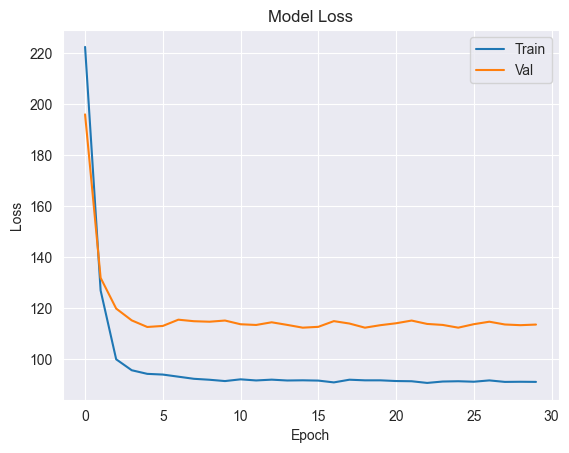

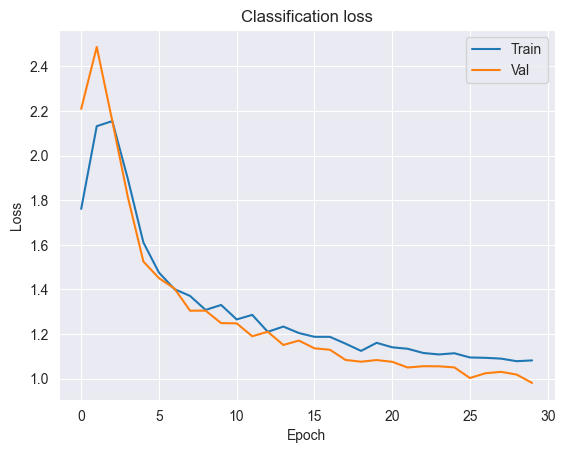

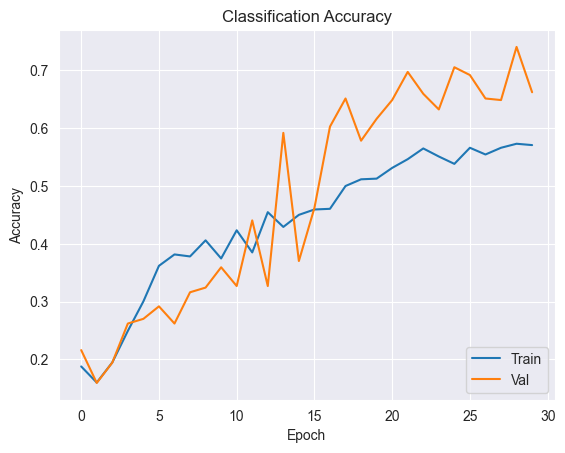

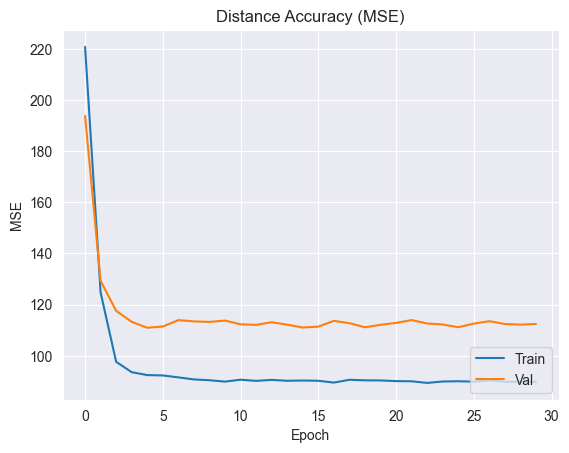

In [32]:
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Add the Dense layer
x = Dense(64, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - class_output_accuracy: 0.3056 - distance_output_mse: 235.3913 - loss: 236.9484 - val_class_output_accuracy: 0.3027 - val_distance_output_mse: 192.7026 - val_loss: 194.2486
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - class_output_accuracy: 0.3085 - distance_output_mse: 145.6437 - loss: 147.4344 - val_class_output_accuracy: 0.3027 - val_distance_output_mse: 128.1038 - val_loss: 129.7213
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - class_output_accuracy: 0.2917 - distance_output_mse: 93.8488 - loss: 95.9951 - val_class_output_accuracy: 0.2784 - val_distance_output_mse: 116.4392 - val_loss: 117.9998
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - class_output_accuracy: 0.3135 - distance_output_mse: 94.5492 - loss: 96.5430 - val_class_output_accuracy: 0.2811 - val_distance_output_mse: 117.0926 - val_loss: 118.5069
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - class_output_accuracy: 0.3097 - distance_output_m

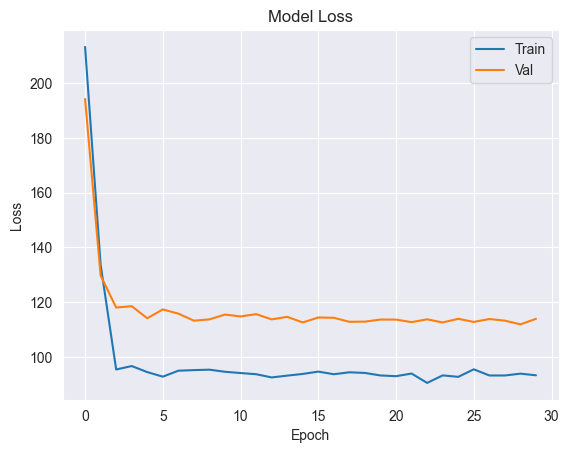

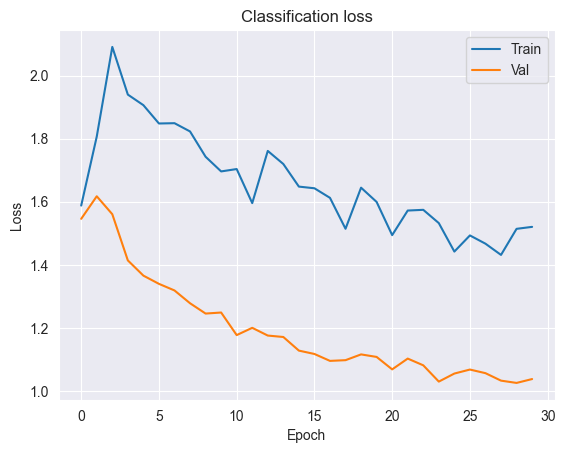

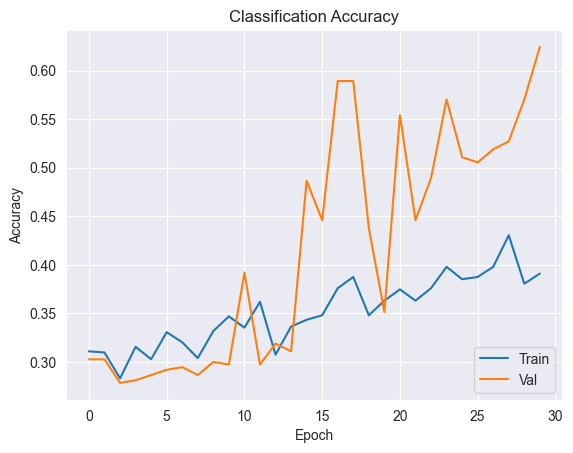

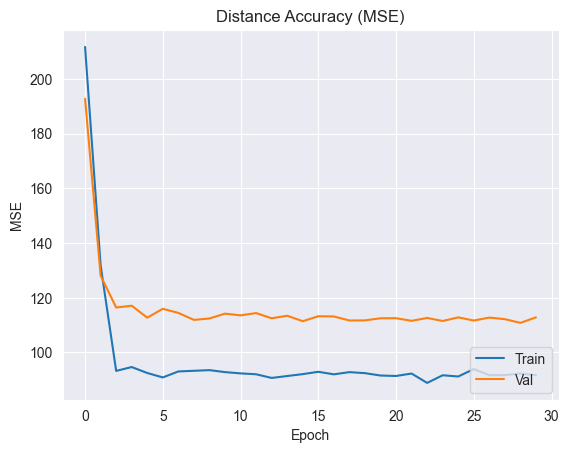

In [34]:

# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)  # Add dropout after the pooling layer
x = Flatten()(x)

# Add the Dense layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)  # Add dropout after the dense layer

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})
trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - class_output_accuracy: 0.2883 - distance_output_mse: 260.8406 - loss: 262.4293 - val_class_output_accuracy: 0.2865 - val_distance_output_mse: 232.0675 - val_loss: 233.9700
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - class_output_accuracy: 0.3471 - distance_output_mse: 185.8028 - loss: 187.6207 - val_class_output_accuracy: 0.2865 - val_distance_output_mse: 193.3089 - val_loss: 195.4773
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - class_output_accuracy: 0.3916 - distance_output_mse: 139.9941 - loss: 141.8258 - val_class_output_accuracy: 0.2892 - val_distance_output_mse: 136.5188 - val_loss: 138.4874
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - class_output_accuracy: 0.3490 - distance_output_mse: 105.6604 - loss: 107.4316 - val_class_output_accuracy: 0.2919 - val_distance_output_mse: 121.2109 - val_loss: 122.9372
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - class_output_accuracy: 0.3625 - distance_output

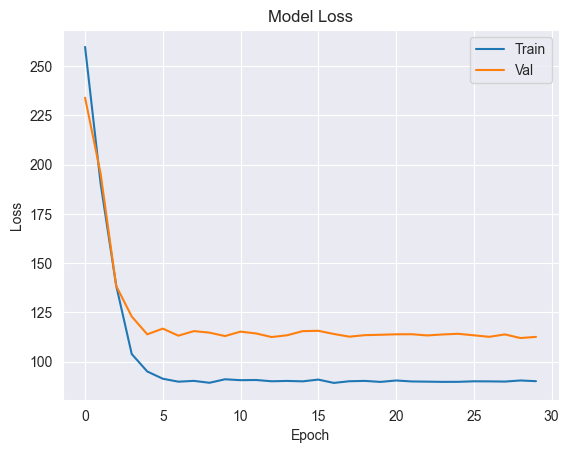

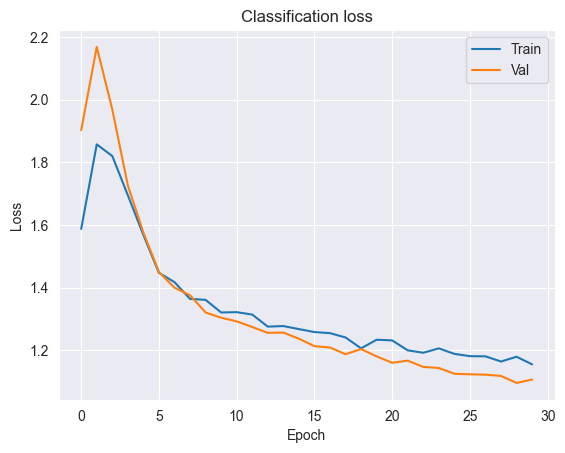

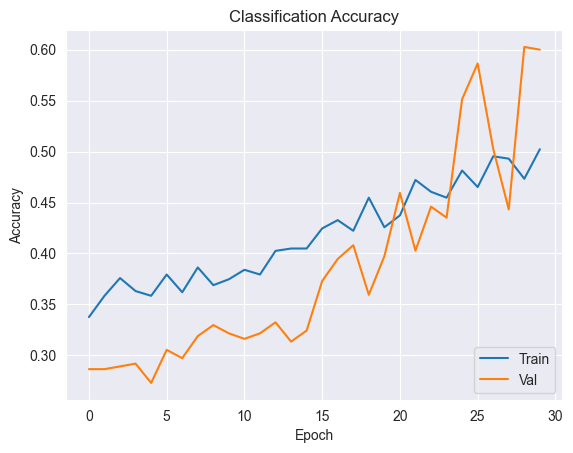

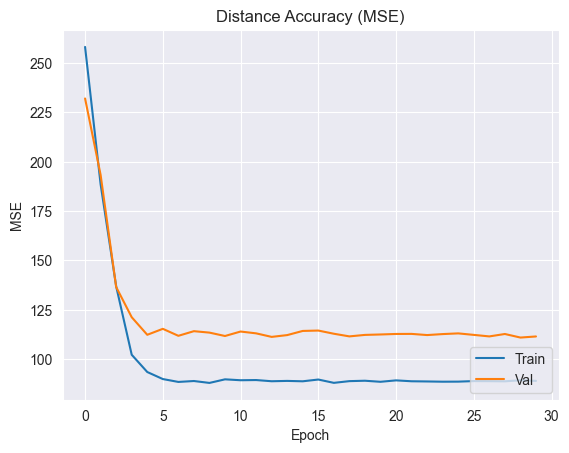

In [36]:

# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(16, (3,3), activation='relu')(input_layer)  # Reduced the number of filters from 32 to 16
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.1)(x)
x = Flatten()(x)

# Add the Dense layer
x = Dense(32, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})
trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator)  # If using a separate test_generator
)


plot_history(trained_model)

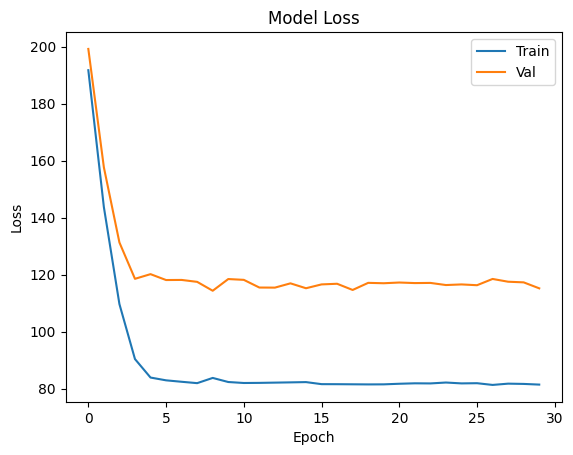

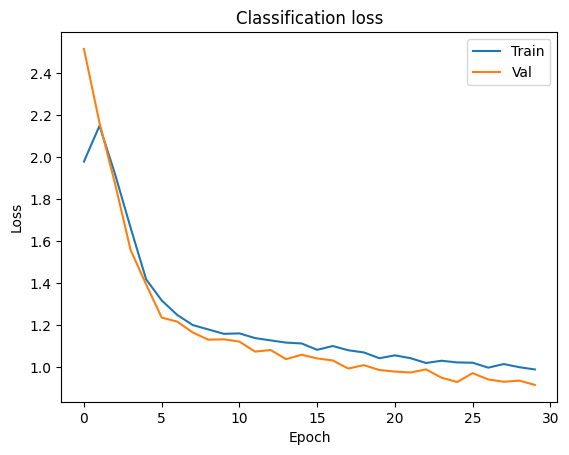

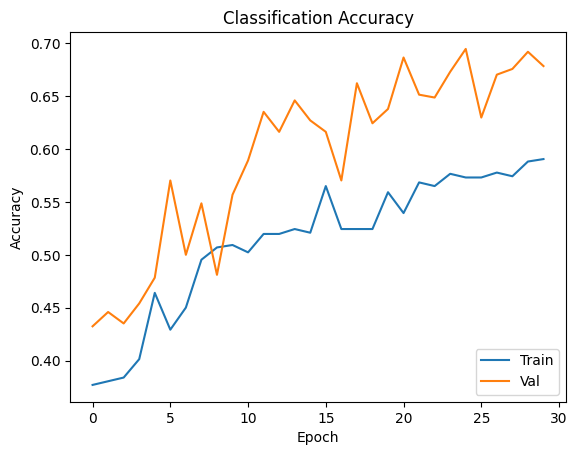

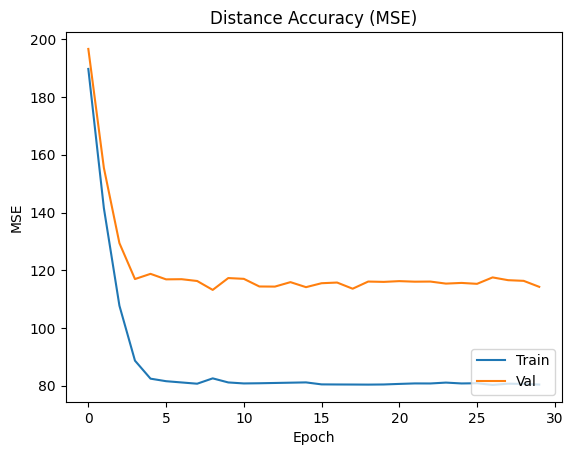

In [10]:

# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(16, (3,3), activation='relu')(input_layer)  # Reduced the number of filters from 32 to 16
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

# Add the Dense layer
x = Dense(32, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mse'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mse'})
trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator),  # If using a separate test_generator
    verbose=0
)


plot_history(trained_model)

In [53]:
img = imread(image_dir + "BluePlayerCapture_3.01_angle2.png")

# Resize the image to (64, 64)
img_resized = resize(img, (64, 64))

# Remove the alpha channel
img_rgb = img_resized[..., :3]

# Predict
model.predict(np.array([img_rgb]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[array([[0.12789422, 0.26930082, 0.0746089 , 0.31026658, 0.21792945]],
       dtype=float32),
 array([[15.24532]], dtype=float32)]

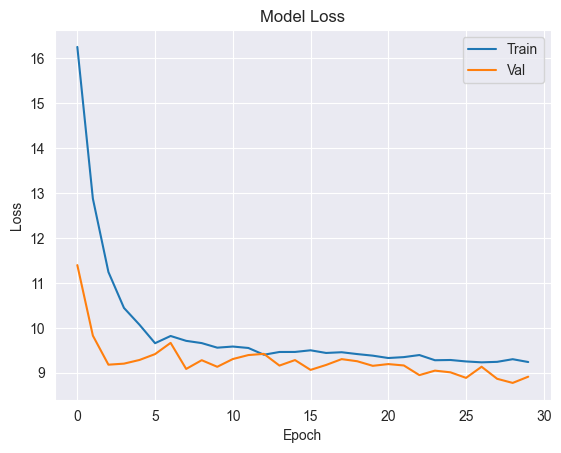

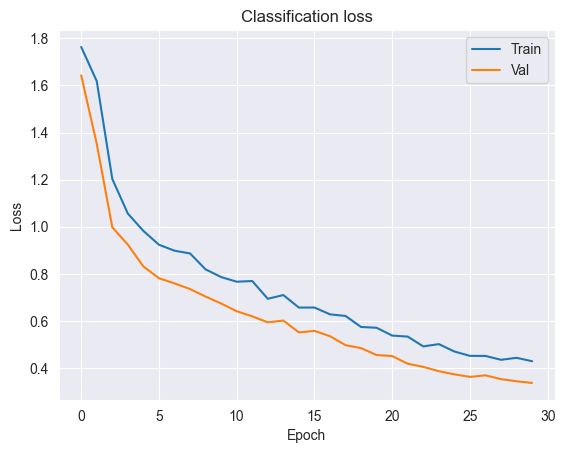

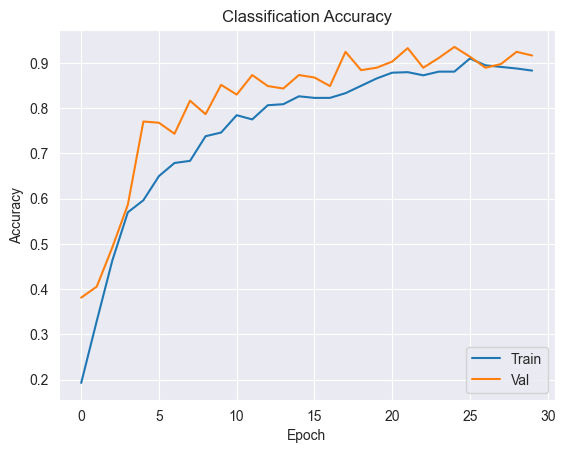

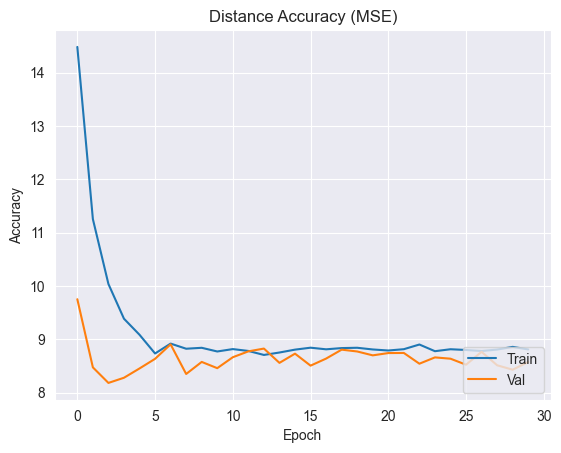

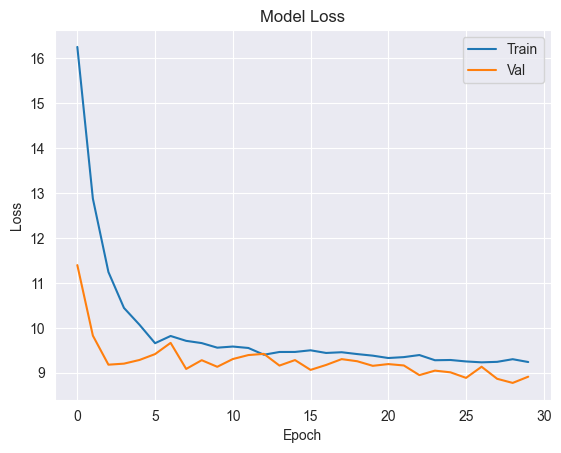

KeyError: 'distance_output_mse'

In [5]:
# Define the input layer
input_layer = Input(shape=(64, 64, 3))

# Add the CNN layer
x = Conv2D(16, (3,3), activation='relu')(input_layer)  # Reduced the number of filters from 32 to 16
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

# Add the Dense layer
x = Dense(32, activation='relu')(x)

# Classification output
class_output = Dense(5, activation='softmax', name='class_output')(x)
# Add a regression output for distance estimation
distance_output = Dense(1, activation='linear', name='distance_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[class_output, distance_output])

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss={'class_output': 'categorical_crossentropy', 'distance_output': 'mae'},
              metrics={'class_output': 'accuracy', 'distance_output': 'mae'})

trained_model = model.fit(
    train_combined_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=test_combined_generator,  # Make sure to create a similar generator for validation data
    validation_steps=len(test_generator) , # If using a separate test_generator
    verbose=0
)

plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(np.array(trained_model.history['loss'])-np.array(trained_model.history['distance_output_mae']))
plt.plot(np.array(trained_model.history['val_loss'])-np.array(trained_model.history['val_distance_output_mae']))
plt.title('Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(trained_model.history['class_output_accuracy'])
plt.plot(trained_model.history['val_class_output_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

plt.plot(trained_model.history['distance_output_mae'])
plt.plot(trained_model.history['val_distance_output_mae'])
plt.title('Distance Accuracy (MSE)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

plot_history(trained_model)

In [12]:
model.save("classification_with.h5")

In [11]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 62, 62,    │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 31, 31,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 31, 31,    │          0 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15376)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │    492,064 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 5)         │        165 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_output     │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,478,132 (5.64 MB)

 Trainable params: 492,710 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 985,422 (3.76 MB)